# Implement Custom Dataset and Fintune Faster RCNN
- You should fill all the **TODO**s in the code.  
- Download custom dataset from https://koreaoffice-my.sharepoint.com/:u:/g/personal/onground_korea_ac_kr/ERo1WvM3k-BNnLB0jLx2CgEB1ybBrWPqxPf-q43MfB_UBw?e=n3AJKb   
    ```
    archive  
        |___ annotations  
        |___ images  
    ```
        
Enjoy!!

In [1]:
import os
from sklearn.model_selection import train_test_split
# from IPython.display import Image

import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from bs4 import BeautifulSoup

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from PIL import Image

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [2]:
img_path = 'archive/images/'
ann_path = 'archive/annotations/'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

data_transforms = transforms.Compose([
        transforms.ToTensor(),
])


### Dataset 확인

In [3]:
imgs = list(sorted(os.listdir(img_path)))
train_ims, test_ims = train_test_split(imgs)
print(len(train_ims), len(test_ims))

639 214


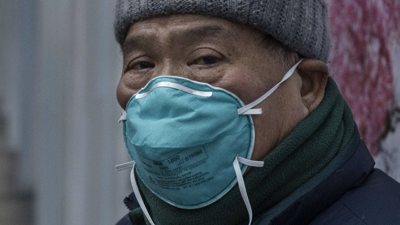

In [4]:
Image.open('archive/images/{}'.format(train_ims[0]))

### Custom Dataset

In [5]:
def generate_box(obj):
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    elif obj.find('name').text == "without_mask":
        return 3
    else:
        return 0

In [6]:
class MaskDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, ann_dir, image_list, transforms):
        self.transforms = transforms
        self.imgs = image_list
        
        self.img_dir, self.ann_dir = img_dir, ann_dir

    def __getitem__(self, idx):
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        
        img_path = os.path.join(self.img_dir, file_image)
        label_path = os.path.join(self.ann_dir, file_label)
        
        img = Image.open(img_path).convert("RGB")
        target = self.__generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return # TODO: return the length of the dataset
    
    @staticmethod
    def __generate_target(image_id, file): 
        with open(file) as f:
            data = f.read()
            soup = BeautifulSoup(data, 'xml')
            objects = soup.find_all('object')

            # get bounding box coordinates for each mask
            boxes = []
            labels = []
            ###################################################################
            # TODO: for each image, get the bounding box coordinates and labels
            # boxes and labels are lists
            # boxes: [[xmin, ymin, xmax, ymax], ...]
            # labels: [label, ...] 
            # label: 1 for with_mask, 2 for mask_weared_incorrect, 3 for without_mask
            ###################################################################
            pass

            ###################################################################

            ###################################################################
            # TODO: convert everything into a torch.Tensor
            # Use torch.as_tensor() to convert a list into a tensor
            # boxes, labels, and image_id should be in tensor format
            pass

            ###################################################################

            # Annotation is in dictionary format
            target = {}
            ###################################################################
            # TODO: for each image, create a dictionary with the following keys
            # "boxes", "labels", "image_id"
            # "boxes": bounding box coordinates
            # "labels": labels
            # "image_id": image id
            # target is a dictionary
            # You should close look at the documentation of the model
            # https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn
            # Faster RCNN model takes in a list of bounding boxes and the corresponding labels
            ###################################################################
            pass
            
            ###################################################################
            return target

def collate_fn(batch) : return tuple(zip(*batch))


In [7]:
# DataLoader 확인

train_data = MaskDataset(img_path, ann_path, train_ims, transforms=data_transforms)
train_data = DataLoader(train_data, batch_size = 1, shuffle = True,
                       collate_fn = collate_fn)

for i, (img, target) in enumerate(train_data):
    print(img[0].shape)
    print(target)
    break

torch.Size([3, 400, 400])
({'boxes': tensor([[ 35., 106., 162., 245.],
        [248., 135., 361., 254.]]), 'labels': tensor([1, 1]), 'image_id': tensor([287])},)


In [8]:
train_dataset = MaskDataset(img_path, ann_path, train_ims, transforms=data_transforms)    
val_dataset = MaskDataset(img_path, ann_path, test_ims, transforms=data_transforms)

###################################################################
# If you are struggling with memory, you can reduce the batch size (e.g. 1 or 2)
# (with batch size 4, you need at least 24GB of GPU memory)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
###################################################################

# For validation, batch size is always 1 because we want to see the result of each image
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

### Model

In [9]:
def get_model_instance_segmentation(num_classes, pretrained=True):
    # load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

###################################################################
num_classes = 4  
# Question 1: Why the number of classes is 4?
# Anwer: TODO: write your answer here
###################################################################

model = get_model_instance_segmentation(num_classes).to(device)


c:\Users\jisan\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jisan\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training

In [10]:
###################################################################
# If your computer is slow, you can reduce the number of epochs (e.g. 1 or 2)
# (It took 1 minutes per epoch on RTX 4090)
num_epochs = 3 
###################################################################
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [11]:
def train_fn():
    model.train()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        progress = tqdm(train_dataloader)
        total_loss = 0.0
        for i, (images, targets) in enumerate(progress):
            if i == 200:
                break

            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            # print(images, targets)
            optimizer.zero_grad()

            losses = model(images, targets)
            loss = sum(loss for loss in losses.values())

            progress.set_description(f"Epoch {epoch + 1}/{num_epochs}, C: {losses['loss_classifier'].item():.5f}, B: {losses['loss_box_reg'].item():.5f}, O: {losses['loss_objectness'].item():.5f}, T: {loss.item():.5f}")
            # print(
            #     f"{epoch}, {i}, C: {losses['loss_classifier'].item():.5f},  "
            #     f"B: {losses['loss_box_reg'].item():.5f}, O: {losses['loss_objectness'].item():.5f}, T: {loss.item():.5f}")
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        lr_scheduler.step()
        print(f"Epoch {epoch + 1} Total loss: {total_loss / len(train_dataloader)}")

        torch.save(model.state_dict(), 'checkpoint.pt')

In [12]:
train_fn()

Epoch 1/1


0it [00:00, ?it/s]

Epoch 1 Total loss: 0.28695789200719446


### Prediction
- If you are struggling with training, you can use this model. (https://koreaoffice-my.sharepoint.com/personal/onground_korea_ac_kr/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fonground_korea_ac_kr%2FDocuments%2F%EA%B3%A0%EB%A0%A4%EB%8C%80%ED%95%99%EA%B5%90%2FAIKU%2FAssignment%203%2Fmodel%2Ezip&parent=%2Fpersonal%2Fonground_korea_ac_kr%2FDocuments%2F%EA%B3%A0%EB%A0%A4%EB%8C%80%ED%95%99%EA%B5%90%2FAIKU%2FAssignment%203&ga=1)  
    - This is a trained checkpoint with num_epochs=10.  
<br>
- You can load the model like this.  

    ```python 
     
    model = torch.load('model.pt')  
    ```

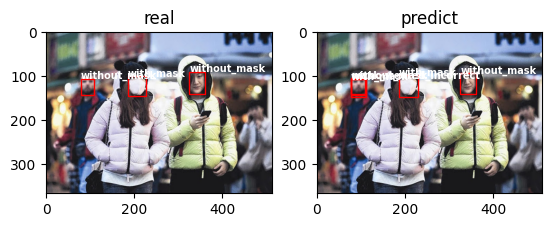

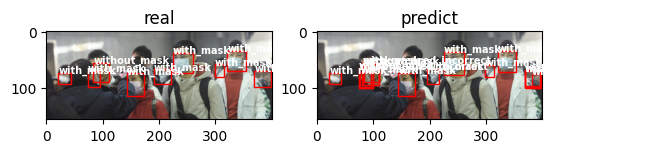

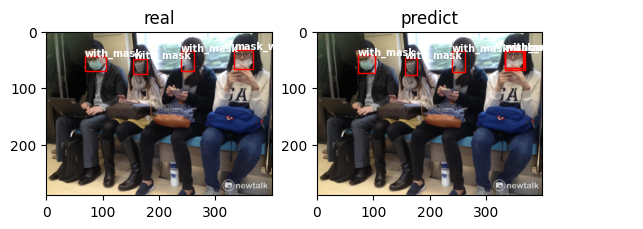

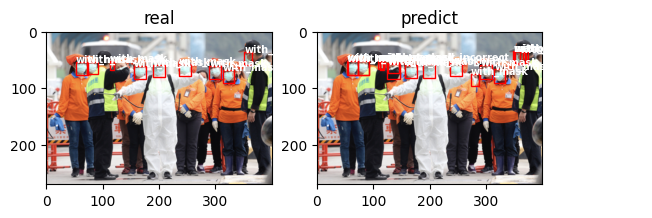

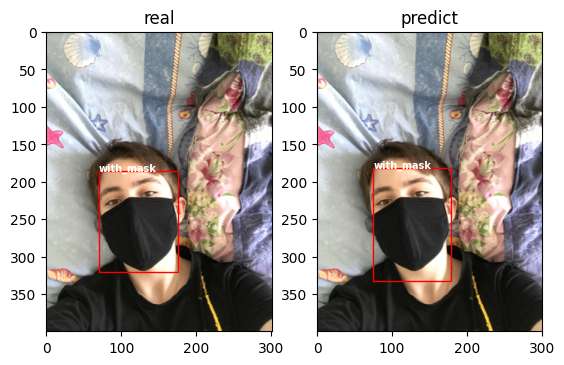

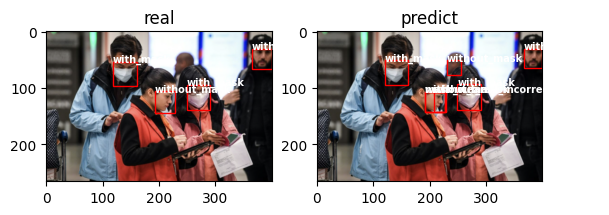

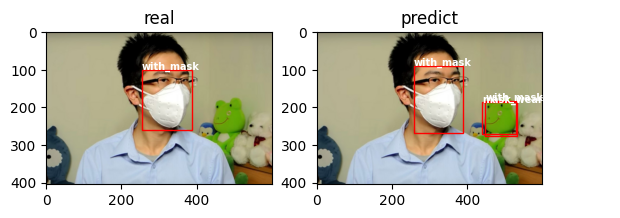

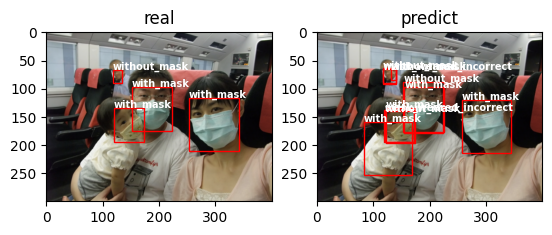

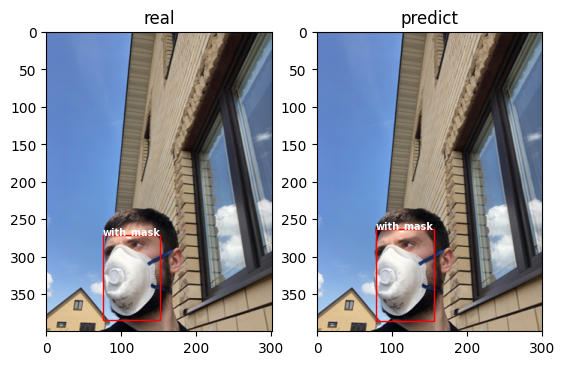

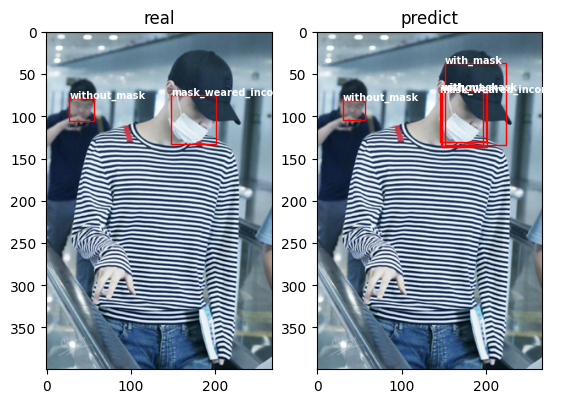

In [16]:
def num_to_class(num):
    if num == 1:
        return 'mask'
    elif num == 2:
        return 'incorrect'
    elif num == 3:
        return 'no_mask'
    else:
        return 'unknown'

def plot_img(img, predict, annotation, test=False):
    if test:
        fig, ax = plt.subplots(1, 2)
        img = img.cpu().data
        predict['boxes'] = predict['boxes'].cpu().data
        predict['labels'] = predict['labels'].cpu().data
        annotation['boxes'] = annotation['boxes'].cpu().data
        annotation['lables'] = annotation['labels'].cpu().data
        
        ax[0].imshow(img.permute(1, 2, 0)) #rgb, w, h => w, h, rgb
        ax[1].imshow(img.permute(1, 2, 0))
        ax[0].set_title("real")
        ax[1].set_title("predict")
        
        for idx, box in enumerate(annotation["boxes"]) :
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
            ax[0].add_patch(rect)
            ax[0].text(xmin, ymin, num_to_class(annotation["labels"][idx]), fontsize=7, color='white', weight='bold')
            
        for idx, box in enumerate(predict["boxes"]) :
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
            ax[1].add_patch(rect)
            ax[1].text(xmin, ymin, num_to_class(predict["labels"][idx]), fontsize=7, color='white', weight='bold')

        plt.show()
    
    else:
        fig, ax = plt.subplots(1, 2)
        img = img.cpu().data
        predict['boxes'] = predict['boxes'].cpu().data
        predict['labels'] = predict['labels'].cpu().data
        
        ax[0].imshow(img.permute(1, 2, 0)) #rgb, w, h => w, h, rgb
        ax[0].set_title("real")
        ax[1].imshow(img.permute(1, 2, 0))
        ax[1].set_title("predict")

        for idx, box in enumerate(predict["boxes"]) :
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
            ax[1].add_patch(rect)
            ax[1].text(xmin, ymin, num_to_class(predict["labels"][idx]), fontsize=7, color='white', weight='bold')

        plt.show()

model.eval()

with torch.no_grad() :
    for idx, (imgs, annotations) in enumerate(val_dataloader):
        if idx == 10 :
            break

        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        
        preds = model(imgs)

        plot_img(imgs[0], preds[0], annotations[0], test=True)

## Your dataset
Try to use the model to your own data. Does it work well?

TODO: If not, write what would have been the problem.

In [ ]:
imgs = []  # TODO: write your image path here

###################################################################
# TODO: Question 2: Why do we need to set model.eval()?
# Answer: TODO: write your answer here
###################################################################
model.eval()

###################################################################
# TODO: Question 3: Why do we need to set torch.no_grad()?
# Answer: TODO: write your answer here
###################################################################

with torch.no_grad():
    for img in imgs:
        img = Image.open(img)
        img = data_transforms(img)
        img = # TODO: write your code here (Hint: use unsqueeze)
        preds = model(img.to(device))
        plot_img(img[0], preds[0], None)

###################################################################
# TODO: Question 4: Why do we need model input to be 4 dimension? What is the meaning of each dimension?
# Answer: TODO: write your answer here
###################################################################